In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import polars as pl
from pathlib import Path
import numpy as np
import re

In [8]:
%cd /home/soda/rcappuzz/work/study-data-lakes/

/home/soda/rcappuzz/work/study-data-lakes


In [9]:
%load_ext autoreload
%autoreload 2
from src import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
pattern = r"(yago_seltab_<)([a-zA-Z_]+)[_0-9]*>"
replacement = r"\g<2>"
def clean_keys(type_name):
    return re.sub(pattern, replacement, type_name)

In [15]:
re.sub(pattern, replacement, "yago_seltab_<wikicat_Living_people>")

'wikicat_Living_people'

# Profile tables

## Profile Type tables

In [30]:
src_path = Path("data/yago3-dl/seltab/")

In [31]:
tab_paths = list(src_path.iterdir())
first_tab = pl.read_parquet(tab_paths[0])

In [32]:
tabs = {}
for tpath in tab_paths:
    tname = tpath.stem
    tab = pl.read_parquet(tpath)
    tabs[tname] = tab


In [33]:
list(tabs.keys())

['yago_seltab_<wordnet_government_108050678>',
 'yago_seltab_<wordnet_country_108544813>',
 'yago_seltab_<wordnet_company_108058098>',
 'yago_seltab_<wikicat_Musical_groups_from_London>',
 'yago_seltab_<wordnet_organization_108008335>',
 'yago_seltab_<wordnet_airport_102692232>',
 'yago_seltab_<wordnet_artist_109812338>',
 'yago_seltab_<wordnet_person_100007846>',
 'yago_seltab_<wordnet_agency_108337324>',
 'yago_seltab_<wordnet_military_unit_108198398>']

In [34]:
q=tab.lazy().select(
    getattr(
        pl.all().old_profiling, x
    )() for x in dir(pl.Expr.old_profiling) if x[:1]!="_"
).melt().with_columns(
    varsplit=pl.col("variable").str.split("___")
).with_columns(
    c1=pl.col("varsplit").arr.first(),
    c2=pl.col("varsplit").arr.last()
).collect()


In [35]:
qq=q.pivot("value", "c1", "c2").to_pandas()
qq["type"] = tname

In [36]:
qq

,c1,count_unique,nan_frac,count_nans,type
0,type,1.0,0.000000,0.0,yago_seltab_<wordnet_military_unit_108198398>
1,subject,27105.0,0.000000,0.0,yago_seltab_<wordnet_military_unit_108198398>
2,<hasWebsite>,987.0,0.373057,34441.0,yago_seltab_<wordnet_military_unit_108198398>
3,<owns>,353.0,0.340941,31476.0,yago_seltab_<wordnet_military_unit_108198398>
4,<isAffiliatedTo>,22.0,0.999350,92261.0,yago_seltab_<wordnet_military_unit_108198398>
5,<isLocatedIn>,696.0,0.712276,65758.0,yago_seltab_<wordnet_military_unit_108198398>
6,<participatedIn>,1746.0,0.313352,28929.0,yago_seltab_<wordnet_military_unit_108198398>
7,<hasWonPrize>,56.0,0.995245,91882.0,yago_seltab_<wordnet_military_unit_108198398>
8,<created>,175.0,0.346433,31983.0,yago_seltab_<wordnet_military_unit_108198398>


In [37]:
prof = utils.profile_with_col_ops(tab)

In [38]:
prof

,stat,type,subject,<hasWebsite>,<owns>,<isAffiliatedTo>,<isLocatedIn>,<participatedIn>,<hasWonPrize>,<created>
0,count,92321.0,92321.0,92321.000000,92321.000000,92321.00000,92321.000000,92321.000000,92321.000000,92321.000000
1,count_unique,1.0,27105.0,987.000000,353.000000,22.00000,696.000000,1746.000000,56.000000,175.000000
2,nan_frac,0.0,0.0,0.373057,0.340941,0.99935,0.712276,0.313352,0.995245,0.346433
3,count_nans,0.0,0.0,34441.000000,31476.000000,92261.00000,65758.000000,28929.000000,91882.000000,31983.000000


In [39]:
full_stats = pd.DataFrame()
for tab_name, tab in tabs.items():
    print(tab_name)
    stats_pl=utils.profile_with_col_ops_v2(tab)
    stats=stats_pl.pivot("value", "c1", "c2").to_pandas()
    stats["type"] = tab_name
    full_stats = pd.concat([full_stats, stats])

yago_seltab_<wordnet_government_108050678>
yago_seltab_<wordnet_country_108544813>
yago_seltab_<wordnet_company_108058098>
yago_seltab_<wikicat_Musical_groups_from_London>
yago_seltab_<wordnet_organization_108008335>
yago_seltab_<wordnet_airport_102692232>
yago_seltab_<wordnet_artist_109812338>
yago_seltab_<wordnet_person_100007846>
yago_seltab_<wordnet_agency_108337324>
yago_seltab_<wordnet_military_unit_108198398>


In [40]:
full_stats["short_type"]=full_stats["type"].apply(clean_keys).str.rstrip("_")

In [46]:
unique_types = full_stats["c1"].nunique()

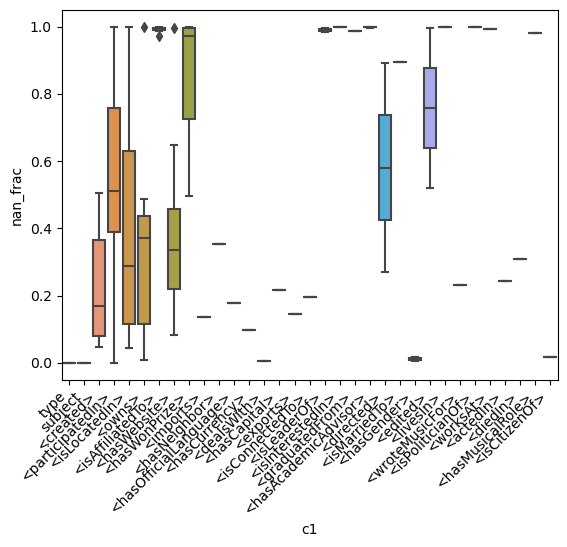

In [41]:
ax=sns.boxplot(data=full_stats, x="c1",y="nan_frac", )
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


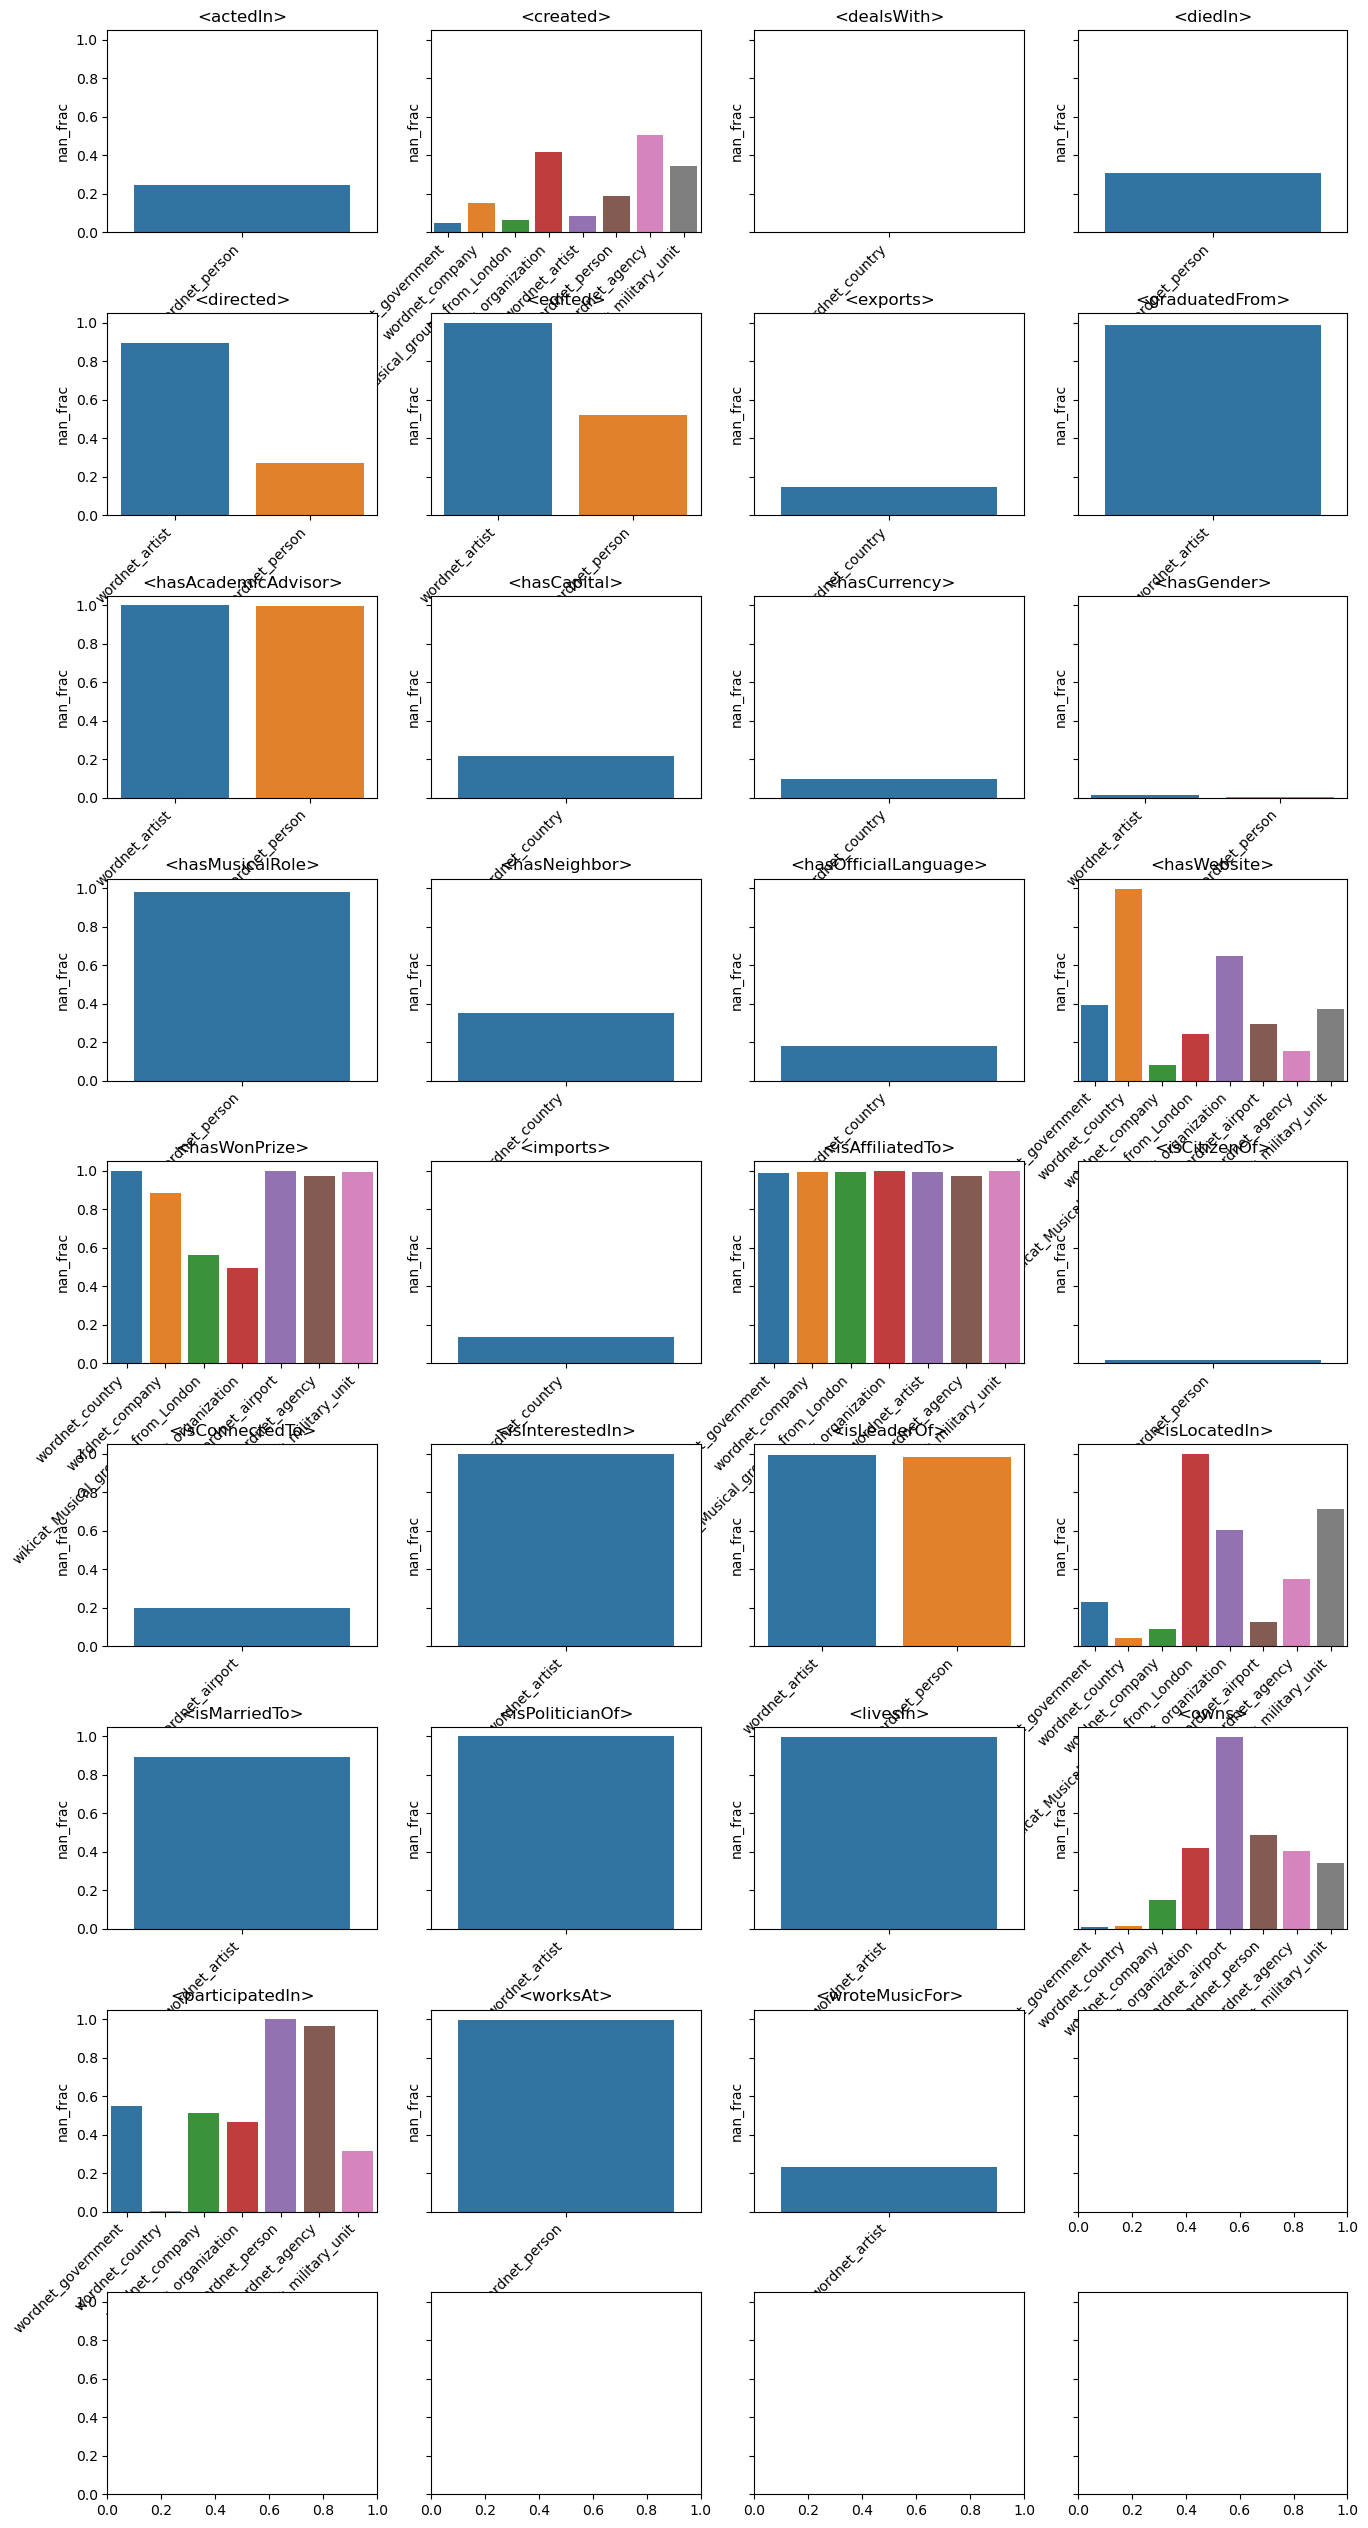

In [48]:
data = full_stats.loc[~full_stats["c1"].isin(["type", "subject"])]
fig, axes = plt.subplots(unique_types//4+1,4, figsize=(16,32), sharey=True, gridspec_kw={"hspace": 0.4})
for idx, (predicate, group) in enumerate(data.groupby("c1")):
    ax = axes[idx//4][idx%4]
    sns.barplot(group, x="short_type", y="nan_frac", ax=ax)
    _=ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(predicate)
    

In [29]:
for tab_name, tab in tabs.items():
    drop_rate = (1-(len(tab.drop_nulls())/len(tab)))*100
    print(f"{tab_name}: {drop_rate:.2f}")

yago_seltab_<wordnet_government_108050678>: 99.01
yago_seltab_<wordnet_country_108544813>: 99.96
yago_seltab_<wordnet_company_108058098>: 99.83
yago_seltab_<wikicat_Musical_groups_from_London>: 100.00
yago_seltab_<wordnet_organization_108008335>: 100.00
yago_seltab_<wordnet_airport_102692232>: 99.98
yago_seltab_<wordnet_artist_109812338>: 100.00
yago_seltab_<wordnet_person_100007846>: 100.00
yago_seltab_<wordnet_agency_108337324>: 99.73
yago_seltab_<wordnet_military_unit_108198398>: 100.00


## Profile binary tables

In [126]:
full_stats["c1"].nunique()

17